<center> <h1><u> Sentiment Classifier</u></h1></center>

<div style="text-align:left">   
<h3> Problem Statement</h3>
     To determine whether a given review is positive or negative.
<h3>Machine Learning Problem</h3>
    Supervised Learning<br>
    Binary Classification<br>
    Natural Language Processing<br>
    Metrics : Accuracy , confusion matrix
</div>

# About data set
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews<br><br>
This dataset consists of reviews of fine foods from amazon.<br> The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012.<br> Reviews include product and user information, ratings, and a plain text review. <br>It also includes reviews from all other Amazon categories.


Data includes :
   - Reviews from Oct 1999 - Oct 2012
   - 568,454 reviews
   - 256,059 users
   - 74,258 products

### Attributes :
   - <b>Id</b>
   - <b>ProductId</b> : Unique identifier for the product
   - <b>UserId</b> : Unqiue identifier for the user
   - <b>ProfileName</b> : Name
   - <b>HelpfulnessNumerator</b> : Number of users who found the review helpful
   - <b>HelpfulnessDenominator</b> : Number of users who indicated whether they found the review helpful or not
   - <b>Score</b> : Rating between 1 and 5
   - <b>Time</b> : Timestamp for the review
   - <b>Summary</b> : Brief summary of the review
   - <b>Text</b> : Review text

#### We can determine the sentiment of the review as "positive" if Score > 3 and "negative" if score < 3

# Importing modules

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

import pickle

In [63]:
# UTILITY FUNCTIONS


# Confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, cbar=False, cmap='viridis', annot=True, fmt='.0f')
    plt.title("Confusion matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    return plt.show()

# Accuracy Scorer
def get_accuracy_score(model,X_train, y_train, X_test, y_test, return_model=False):
    model = model.fit(X_train, y_train)
    y_preds_train = model.predict(X_train)
    y_preds = model.predict(X_test)
    print("Train accuracy:", accuracy_score(y_train, y_preds_train))
    print("Test accuracy:", accuracy_score(y_test, y_preds))
    print()
    return model if return_model==True else None


In [66]:
# Loading data into memory
data = pd.read_csv('Reviews.csv')
print("No. of rows :", data.shape[0])
data.head(3)

No. of rows : 568454


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [67]:
# Check null values
data.isna().sum().to_frame(name='# Missing values')

,# Missing values
Id,0
ProductId,0
UserId,0
ProfileName,16
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [69]:
# Remove rows which are having null values

total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 43

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


In [70]:
# Remove rows where Score == 3

a =  data.shape[0]
data = data.loc[data.Score != 3]
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 42638

Percentage of data removed:7.5%
Percentage of data remaining:92.49%


### Add Sentiment variable :
1 -- positive review<br>
0 -- negative review<br>

Sentiment == 1 if Score > 3 <br>
Sentiment == 0 if Score < 3


In [71]:
data.loc[:, "Sentiment"] = data.Score.apply(lambda x : 1 if x > 3 else 0)

In [72]:
# Select input and target variables

data = data[["Text", "Sentiment"]]
data.head()

,Text,Sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [74]:
# Remove dupicate rows

a =  data.shape[0]
data.drop_duplicates(inplace=True)
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 161944

Percentage of data removed: 28.49%
Percentage of data remaining: 64.0%


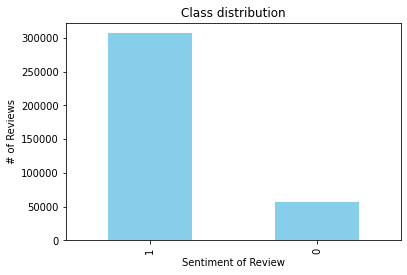

In [75]:
# Class distribution
fig = data.Sentiment.value_counts().plot.bar(color='skyblue')
fig.set_title("Class distribution")
fig.set_ylabel("# of Reviews")
fig.set_xlabel("Sentiment of Review")
plt.show()

Observation:<br> It is a highly imbalanced dataset.<br>Positive reviews are dominant class.


# Down Sampling

In [76]:
#negative reviews
neg_data = data.loc[data.Sentiment == 0]

# positive reviews
pos_data = data.loc[data.Sentiment == 1][:neg_data.shape[0]]

# balanced data
a = data.shape[0]
data = pd.concat([pos_data, neg_data])
data = data.sample(frac=1, random_state=1)
b = data.shape[0]


print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 249693

Percentage of data removed: 43.92%
Percentage of data remaining: 20.08%


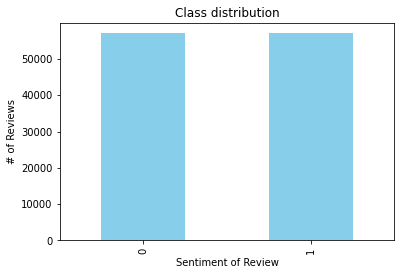

In [77]:
# Class distribution
fig = data.Sentiment.value_counts().plot.bar(color='skyblue')
fig.set_title("Class distribution")
fig.set_ylabel("# of Reviews")
fig.set_xlabel("Sentiment of Review")
plt.show()

In [80]:
# Final data is around 114k which is enough for our modelling
print(data.shape)

(114136, 2)


In [81]:
# Credits:
# https://pymotw.com/2/re/
# https://stackoverflow.com/questions/19084443/replacing-digits-with-str-replace
# https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string

total_stopwords = set(stopwords.words('english'))
negative_stop_words = set(word for word in total_stopwords if "n't" in word or 'no' in word)
# subtract negative stop words like no, not, don't etc.. from total_stopwords
final_stopwords = total_stopwords.symmetric_difference(negative_stop_words)
stemmer = PorterStemmer()

def preprocessor(review):
    # remove html tags
    HTMLTAGS = re.compile('<.*?>')
    review = HTMLTAGS.sub(r'', review)
    # remove puncutuation
    table = str.maketrans(dict.fromkeys(string.punctuation))
    review = review.translate(table)
    # remove digits
    remove_digits = str.maketrans('', '', string.digits)
    review = review.translate(remove_digits)
    # lower case all letters
    review = review.lower()
    # replace multiple white spaces with single space
    MULTIPLE_WHITESPACE = re.compile(r"\s+")
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    # remove stop words
    review = [word for word in review.split() if word not in final_stopwords]
    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])
    return review

# Data cleaning

In [84]:
X = data['Text']
y = data['Sentiment']

In [83]:
X.head(3)

39884     Tis decafinated tea is good tasting and makes ...
130039    not sure why the excessive price...is there a ...
387193    Full of sugar.  I like the recyclable cans but...
Name: Text, dtype: object

In [86]:
X = X.apply(preprocessor)

In [87]:
X.head(3)

39884     ti decafin tea good tast make digest system wo...
130039    not sure excess pricei run nondairi nonsteroid...
387193    full sugar like recycl can not sugar besid fal...
Name: Text, dtype: object

In [88]:
# Data splitting :train - test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [89]:
# Tfidf-vectorizer
vectorizer = TfidfVectorizer(max_features=15000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=15000)

In [90]:
tfidf_X_train = vectorizer.transform(X_train)
tfidf_X_test = vectorizer.transform(X_test)

# 4. Machine Learning
- Classification Algorithms
    - Multinomial Naive Bayes
    - Logistic regression
    

- Metrics
    - accuracy
  


## Base model : Multinomial Naive Bayes

In [92]:
get_accuracy_score(MultinomialNB(),tfidf_X_train, y_train, tfidf_X_test, y_test)

Train accuracy: 0.8815798696292143
Test accuracy: 0.8618139763089647



## Logistic regression

In [94]:
get_accuracy_score(LogisticRegression(),tfidf_X_train, y_train, tfidf_X_test, y_test)

Train accuracy: 0.9063222821896685
Test accuracy: 0.889009602579379



### Hyper parameter tuning

In [96]:
search = GridSearchCV(cv=None,
                      estimator=LogisticRegression(),
                      param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
                      scoring='accuracy',
                      n_jobs=-1)
search.fit(tfidf_X_train, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [97]:
print(search.best_score_)

0.8878530874528575


In [98]:
print(search.best_estimator_)

LogisticRegression(C=1)


In [100]:
# Training final model
final_model = get_accuracy_score(search.best_estimator_,
                           tfidf_X_train, y_train,
                           tfidf_X_test, y_test,
                           return_model=True)

Train accuracy: 0.9063222821896685
Test accuracy: 0.889009602579379



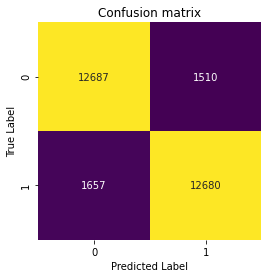

In [101]:
#Confusion matrix
y_pred = final_model.predict(tfidf_X_test)
plot_confusion_matrix(y_test, y_pred)

### Save the vectorizer and final model

In [102]:
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)

In [ ]:
#########################Self-check ################################

In [103]:
text = data.loc[0].values[0]
text
# label = 1

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [106]:
with open("tfidf_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

with open("model.pkl", "rb") as f:
    model = pickle.load(f)

In [117]:
def predict(text):
    review = preprocessor(text)
    x = vectorizer.transform([review])
    y = model.predict(x)[0]
    return y

In [118]:
predict(text)

1